## EM Algorithm 
* A simple example of EM 
* EM algorithm for classfication of height and weight with gender as latent parameter
* BIC
* EM Algorithm on Iris Data
* Dirichlet Process Gaussian Mixture Model
* GMM Likelihood Contours


In [35]:
# a simple EM example
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances_argmin
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

In [36]:
style = 'sklearn'  # use GaussianMixture from sklearn, else use the written function 
np.random.seed(0)
mu1_fact = (0, 0, 0)
cov_fact = np.identity(3)
print('Covariance: \n', cov_fact)
data1 = np.random.multivariate_normal(mu1_fact, cov_fact, 400) # data1 400 samples 
mu2_fact = (2, 2, 1)
cov_fact = np.identity(3)
data2 = np.random.multivariate_normal(mu2_fact, cov_fact, 100) # data2 100 samples
data = np.vstack((data1, data2))  # combine the two data sets 
y = np.array([True] * 400 + [False] * 100)  # indicator
len(y)
# help(GaussianMixture)

Covariance: 
 [[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]


500

In [38]:
# if style = 'sklearn', use the GaussianMixture function from sklearn for model fitting; 
# else, use the function written by ourselves 

# style = 'test'
# style = "sklearn"
if style == 'sklearn':
    g = GaussianMixture(n_components=2, covariance_type='full', tol=1e-6, max_iter=5000)
    # n.components: The number of mixture components.
    # covariance_type full : each component has its own general covariance matrix
    g.fit(data)
    print ('Mixture Components Weights:\t', g.weights_) # The weights of each mixture components
    print ('Mean:\n', g.means_, '\n') # The mean of each mixture component.
    print ('Covariance:\n', g.covariances_, '\n') # The covariance of each mixture component.
    mu1, mu2 = g.means_
    sigma1, sigma2 = g.covariances_
else:
    num_iter = 100
    n, d = data.shape
    # 随机指定
    # mu1 = np.random.standard_normal(d)
    # print (mu1)
    # mu2 = np.random.standard_normal(d)
    # print mu2
    mu1 = data.min(axis=0)
    mu2 = data.max(axis=0)
    sigma1 = np.identity(d)
    sigma2 = np.identity(d)
    pi = 0.5 # initial weight
    
    # EM Algorithm
    for i in range(num_iter):
        # E Step
        norm1 = multivariate_normal(mu1, sigma1)
        norm2 = multivariate_normal(mu2, sigma2)
        tau1 = pi * norm1.pdf(data)  # probability density function
        tau2 = (1 - pi) * norm2.pdf(data)
        gamma = tau1 / (tau1 + tau2)

        # M Step
        mu1 = np.dot(gamma, data) / np.sum(gamma)
        mu2 = np.dot((1 - gamma), data) / np.sum((1 - gamma))
        sigma1 = np.dot(gamma * (data - mu1).T, data - mu1) / np.sum(gamma)
        sigma2 = np.dot((1 - gamma) * (data - mu2).T, data - mu2) / np.sum(1 - gamma)
        pi = np.sum(gamma) / n
        print (i, ":\t", mu1, mu2)
    print ('Mixture Components Weights:\t', pi)
    print ('Mean:\t', mu1, mu2)
    print ('Covariance:\n', sigma1, '\n\n', sigma2, '\n')
# help(multivariate_normal)

Mixture Components Weights:	 [ 0.74410403  0.25589597]
Mean:
 [[-0.07255166 -0.06875491 -0.12428664]
 [ 1.74652944  1.76401045  0.92998549]] 

Covariance:
 [[[ 0.85645342 -0.09625984 -0.02439478]
  [-0.09625984  1.01121453 -0.09640856]
  [-0.02439478 -0.09640856  0.85564497]]

 [[ 1.1279412   0.04945608 -0.00666527]
  [ 0.04945608  1.14114602  0.06399139]
  [-0.00666527  0.06399139  0.8886593 ]]] 



Order : 
 [0 1]
Accuracy：90.80%


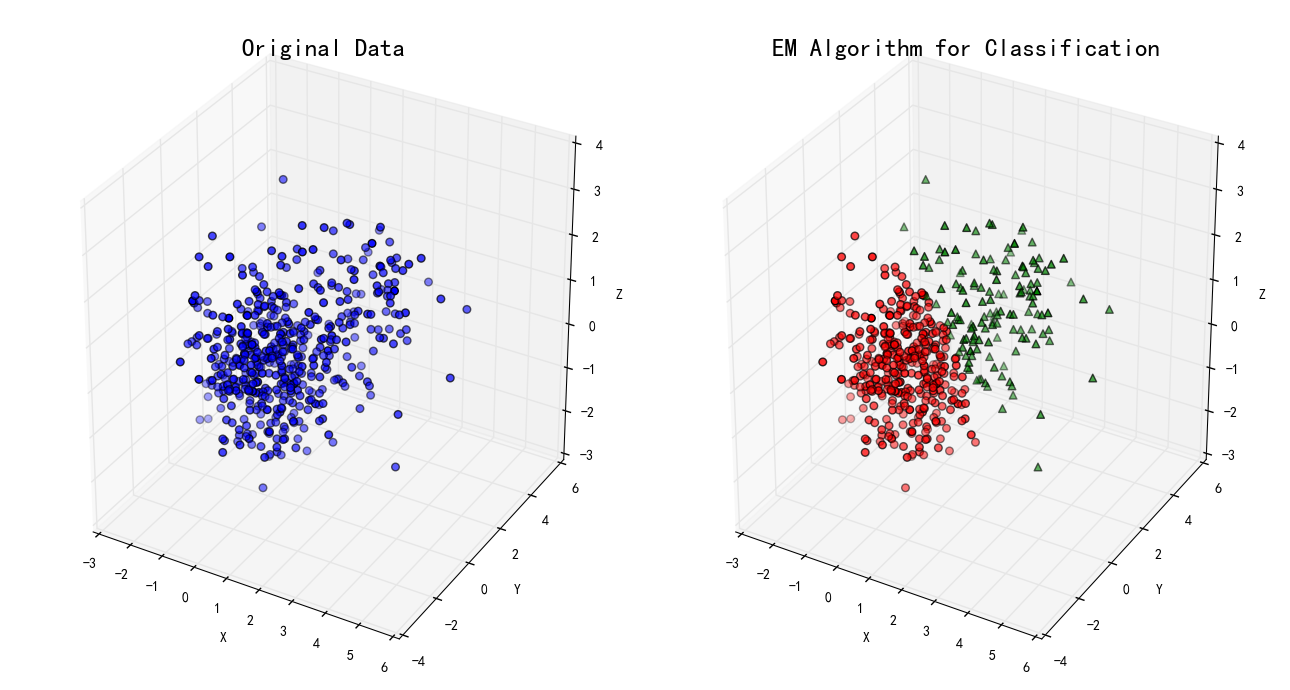

In [39]:
 # Predict the classification of the data (from data1 or data2)
norm1 = multivariate_normal(mu1, sigma1)
norm2 = multivariate_normal(mu2, sigma2)
tau1 = norm1.pdf(data)
tau2 = norm2.pdf(data)

fig = plt.figure(figsize=(13, 7), facecolor='w')
ax = fig.add_subplot(121, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='b', s=30, marker='o', depthshade=True)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Original Data', fontsize=18)
ax = fig.add_subplot(122, projection='3d')
# check if the estimate mu1 corresponds to mu1_fact or mu2_fact
order = pairwise_distances_argmin([mu1_fact, mu2_fact], [mu1, mu2], metric='euclidean')
print('Order : \n', order)
if order[0] == 0:
    c1 = tau1 > tau2
else:
    c1 = tau1 < tau2
c2 = ~c1
acc = np.mean(y == c1)
print ('Accuracy：%.2f%%' % (100*acc))
ax.scatter(data[c1, 0], data[c1, 1], data[c1, 2], c='r', s=30, marker='o', depthshade=True)
ax.scatter(data[c2, 0], data[c2, 1], data[c2, 2], c='g', s=30, marker='^', depthshade=True)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(u'EM Algorithm for Classification', fontsize=18)
# plt.suptitle(u'EM', fontsize=20)
# plt.subplots_adjust(top=0.92)
plt.tight_layout()
plt.show()


### EM algorithm for classfication of height and weight with gender as latent parameter

In [88]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import matplotlib as mpl
import matplotlib.colors
import matplotlib.pyplot as plt
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False
# from matplotlib.font_manager import FontProperties
# font_set = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=15)
# fontproperties=font_set




In [89]:
data = np.loadtxt('Data-and-Output/HeightWeight.csv', dtype=np.float, delimiter=',', skiprows=1)
print ('y dimension',data.shape)
y, x = np.split(data, [1, ], axis=1)

# split the data into training and testing sets 
x, x_test, y, y_test = train_test_split(x, y, train_size=0.6, random_state=0)
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
x_min = np.min(x, axis=0)
x_max = np.max(x, axis=0)
gmm.fit(x)
print ('Mean = \n', gmm.means_)
print ('Covariance = \n', gmm.covariances_)
y_hat = gmm.predict(x)  # predict on training set 
y_test_hat = gmm.predict(x_test) # predict on testing set 
change = (gmm.means_[0][0] > gmm.means_[1][0]) # check the order of two means so the smaller mean is the first one

y dimension (114, 3)
Mean = 
 [[ 160.13983374   55.93370575]
 [ 173.50243688   65.03359308]]
Covariance = 
 [[[  18.82128194   12.30370549]
  [  12.30370549   31.23596113]]

 [[  23.22794989   28.48688647]
  [  28.48688647  105.81824734]]]


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [90]:
if change:
    z = y_hat == 0
    y_hat[z] = 1
    y_hat[~z] = 0
    z = y_test_hat == 0
    y_test_hat[z] = 1
    y_test_hat[~z] = 0
acc = np.mean(y_hat.ravel() == y.ravel())
acc_test = np.mean(y_test_hat.ravel() == y_test.ravel())
acc_str = 'Training set accuracy：%.2f%%' % (acc * 100)
acc_test_str = 'Testing set accuracy：%.2f%%' % (acc_test * 100)
print (acc_str)
print (acc_test_str)
# help(expand)
# help(plt.scatter)

Training set accuracy：77.94%
Testing set accuracy：82.61%


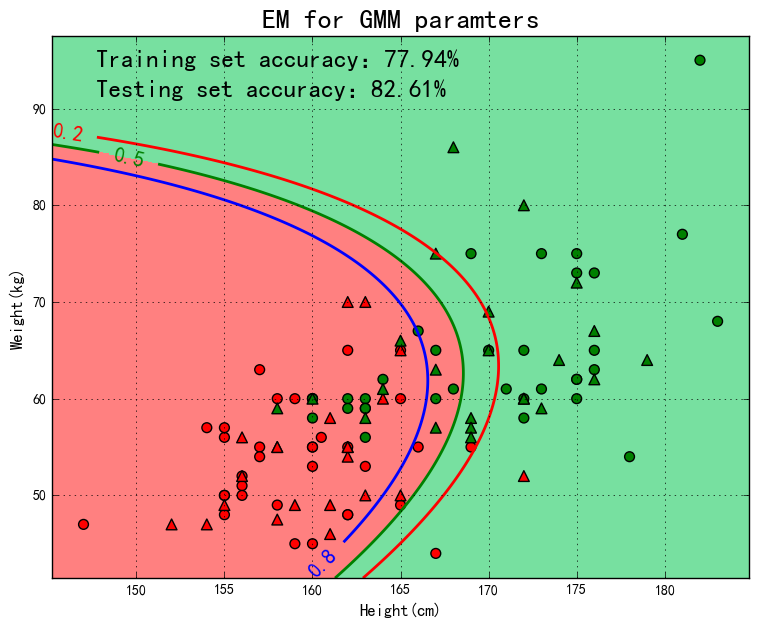

In [91]:
# expand the (a, b) range a little
def expand(a, b):
    d = (b - a) * 0.05
    return a-d, b+d

# plot the data
cm_light = mpl.colors.ListedColormap(['#FF8080', '#77E0A0'])
cm_dark = mpl.colors.ListedColormap(['r', 'g']) # red , green 
x1_min, x1_max = x[:, 0].min(), x[:, 0].max()
x2_min, x2_max = x[:, 1].min(), x[:, 1].max()
x1_min, x1_max = expand(x1_min, x1_max)
x2_min, x2_max = expand(x2_min, x2_max)
x1, x2 = np.mgrid[x1_min:x1_max:500j, x2_min:x2_max:500j]
grid_test = np.stack((x1.flat, x2.flat), axis=1) #  all grid values to be predicted  for background color and contour
grid_hat = gmm.predict(grid_test)
grid_hat = grid_hat.reshape(x1.shape)
if change:
    z = grid_hat == 0
    grid_hat[z] = 1
    grid_hat[~z] = 0
plt.figure(figsize=(9, 7), facecolor='w')
plt.pcolormesh(x1, x2, grid_hat, cmap=cm_light) #predictions on grid values for background color
plt.scatter(x[:, 0], x[:, 1], s=50, c=y, marker='o', cmap=cm_dark, edgecolors='k')
plt.scatter(x_test[:, 0], x_test[:, 1], s=60, c=y_test, marker='^', cmap=cm_dark, edgecolors='k')

p = gmm.predict_proba(grid_test) # make prediction 
p = p[:, 0].reshape(x1.shape)
CS = plt.contour(x1, x2, p, levels=(0.2, 0.5, 0.8), colors=list('rgb'), linewidths=2) # contour
plt.clabel(CS, fontsize=15, fmt='%.1f', inline=True)
ax1_min, ax1_max, ax2_min, ax2_max = plt.axis()
xx = 0.9*ax1_min + 0.1*ax1_max
yy = 0.1*ax2_min + 0.9*ax2_max
plt.text(xx, yy, acc_str, fontsize=18)
yy = 0.15*ax2_min + 0.85*ax2_max
plt.text(xx, yy, acc_test_str, fontsize=18) # add text to plot
plt.xlim((x1_min, x1_max))
plt.ylim((x2_min, x2_max))
plt.xlabel(u'Height(cm)', fontsize='large')
plt.ylabel(u'Weight(kg)', fontsize='large')
plt.title(u'EM for GMM paramters', fontsize=20)
plt.grid()
plt.show()


### BIC 

In [99]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib as mpl
import matplotlib.colors
import matplotlib.pyplot as plt
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

def expand(a, b, rate=0.05):
    d = (b - a) * rate
    return a-d, b+d


def accuracy_rate(y1, y2):
    acc = np.mean(y1 == y2)
    return acc if acc > 0.5 else 1-acc


In [100]:
np.random.seed(0)
cov1 = np.diag((1, 2))
N1 = 500
N2 = 300
N = N1 + N2
x1 = np.random.multivariate_normal(mean=(1, 2), cov=cov1, size=N1)
# construct new data 
m = np.array(((1, 1), (1, 3)))  
x1 = x1.dot(m) # new data
x2 = np.random.multivariate_normal(mean=(-1, 10), cov=cov1, size=N2)
x = np.vstack((x1, x2))
y = np.array([0]*N1 + [1]*N2)

types = ('spherical', 'diag', 'tied', 'full')
err = np.empty(len(types))
bic = np.empty(len(types))
# print(len(types))
for i, type in enumerate(types):
    gmm = GaussianMixture(n_components=2, covariance_type=type, random_state=0)
    gmm.fit(x)
    err[i] = 1 - accuracy_rate(gmm.predict(x), y)
    bic[i] = gmm.bic(x)
print ('Error Rate：', err.ravel())
print ('BIC：', bic.ravel())
print(accuracy_rate(gmm.predict(x), y))


Error Rate： [ 0.385    0.315    0.3      0.00125]
BIC： [ 7990.71460065  7855.56050855  8006.49834359  6845.79374805]
0.99875


[0 1 2 3]


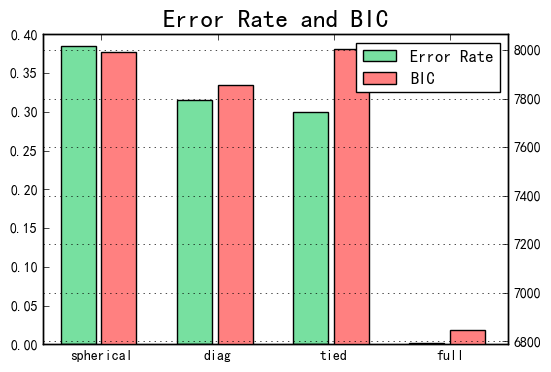

In [105]:
xpos = np.arange(4) # four bars 
print(xpos)
ax = plt.axes()
b1 = ax.bar(xpos-0.35, err, width=0.3, color='#77E0A0')
b2 = ax.twinx().bar(xpos, bic, width=0.3, color='#FF8080') # add red bars (two/twin x axes)
plt.grid(True)
bic_min, bic_max = expand(bic.min(), bic.max())
plt.ylim((bic_min, bic_max))
plt.xticks(xpos, types)
plt.legend([b1[0], b2[0]], ('Error Rate', 'BIC'))
plt.title('Error Rate and BIC', fontsize=18)
plt.show()

In [110]:
# help(bic.argmin) # return indices of the minimum values along the given axis of `a`.
optimal = bic.argmin()
print(optimal) # the 4th with indice 3
gmm = GaussianMixture(n_components=2, covariance_type=types[optimal], random_state=0)
gmm.fit(x)
print ('Mean = \n', gmm.means_)
print ('Covariance = \n', gmm.covariances_)
y_hat = gmm.predict(x)

3
Mean = 
 [[ -0.97642254  10.06927801]
 [  2.88444448   6.69484552]]
Covariance = 
 [[[  0.91302546  -0.04298504]
  [ -0.04298504   1.9603531 ]]

 [[  2.87015473   6.64421303]
  [  6.64421303  18.00318872]]]


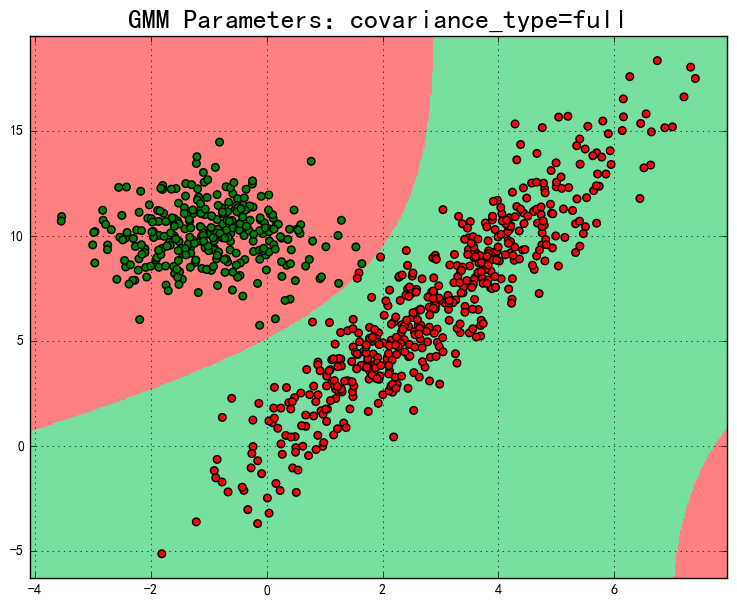

In [112]:
# plot
cm_light = mpl.colors.ListedColormap(['#FF8080', '#77E0A0'])
cm_dark = mpl.colors.ListedColormap(['r', 'g'])
x1_min, x1_max = x[:, 0].min(), x[:, 0].max()
x2_min, x2_max = x[:, 1].min(), x[:, 1].max()
x1_min, x1_max = expand(x1_min, x1_max)
x2_min, x2_max = expand(x2_min, x2_max)
x1, x2 = np.mgrid[x1_min:x1_max:500j, x2_min:x2_max:500j]
grid_test = np.stack((x1.flat, x2.flat), axis=1)
grid_hat = gmm.predict(grid_test)
grid_hat = grid_hat.reshape(x1.shape)
if gmm.means_[0][0] > gmm.means_[1][0]:
    z = grid_hat == 0
    grid_hat[z] = 1
    grid_hat[~z] = 0
plt.figure(figsize=(9, 7), facecolor='w')
plt.pcolormesh(x1, x2, grid_hat, cmap=cm_light)
plt.scatter(x[:, 0], x[:, 1], s=30, c=y, marker='o', cmap=cm_dark, edgecolors='k')

ax1_min, ax1_max, ax2_min, ax2_max = plt.axis()
plt.xlim((x1_min, x1_max))
plt.ylim((x2_min, x2_max))
plt.title('GMM Parameters：covariance_type=%s' % types[optimal], fontsize=20)
plt.grid()
plt.show()


### EM Algorithm on Iris Data

In [113]:

import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib as mpl
import matplotlib.colors
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances_argmin

mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False

iris_feature = 'Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width'


def expand(a, b, rate=0.05):
    d = (b - a) * rate
    return a-d, b+d


def iris_type(s):
    it = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
    return it[s]
classes = {b'Iris-setosa': 0, b'Iris-versicolor': 1, b'Iris-virginica': 2}

In [124]:
path = 'Data-and-Output/8.iris.data'  # data path
data = np.loadtxt(path, dtype=float, delimiter=',', converters={4: lambda x: classes[x]})
# set x, y accordingly
x_prime, y = np.split(data, (4,), axis=1)
y = y.ravel()

n_components = 3
# test different pairs of features
feature_pairs = [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]


In [130]:
# difference of two loops
for pair in enumerate(feature_pairs):
     print(pair)
for k, pair in enumerate(feature_pairs):
     print(k, pair)

(0, [0, 1])
(1, [0, 2])
(2, [0, 3])
(3, [1, 2])
(4, [1, 3])
(5, [2, 3])
0 [0, 1]
1 [0, 2]
2 [0, 3]
3 [1, 2]
4 [1, 3]
5 [2, 3]


Actual Mean = 
 [[ 5.006  3.418]
 [ 5.936  2.77 ]
 [ 6.588  2.974]]
Predicted Mean = 
 [[ 5.01494511  3.44040237]
 [ 6.69225795  3.03018616]
 [ 5.90652226  2.74740414]]
Predicted Covariance = 
 [[[ 0.11948421  0.08969613]
  [ 0.08969613  0.12149899]]

 [[ 0.3588512   0.05091598]
  [ 0.05091598  0.08956947]]

 [[ 0.27590209  0.08910477]
  [ 0.08910477  0.09414053]]]
Order：	 [0 2 1]
Accuracy Rate：78.67%
Actual Mean = 
 [[ 5.006  1.464]
 [ 5.936  4.26 ]
 [ 6.588  5.552]]
Predicted Mean = 
 [[ 5.0060006   1.46399865]
 [ 6.04240777  4.41742864]
 [ 6.58888904  5.63329718]]
Predicted Covariance = 
 [[[ 0.12176525  0.01581631]
  [ 0.01581631  0.0295045 ]]

 [[ 0.28119672  0.23746926]
  [ 0.23746926  0.31503012]]

 [[ 0.48521779  0.36602418]
  [ 0.36602418  0.32601109]]]
Order：	 [0 1 2]
Accuracy Rate：91.33%
Actual Mean = 
 [[ 5.006  0.244]
 [ 5.936  1.326]
 [ 6.588  2.026]]
Predicted Mean = 
 [[ 5.00605757  0.23727675]
 [ 6.57289666  2.05192938]
 [ 5.977111    1.33910201]]
Predicted Covariance 

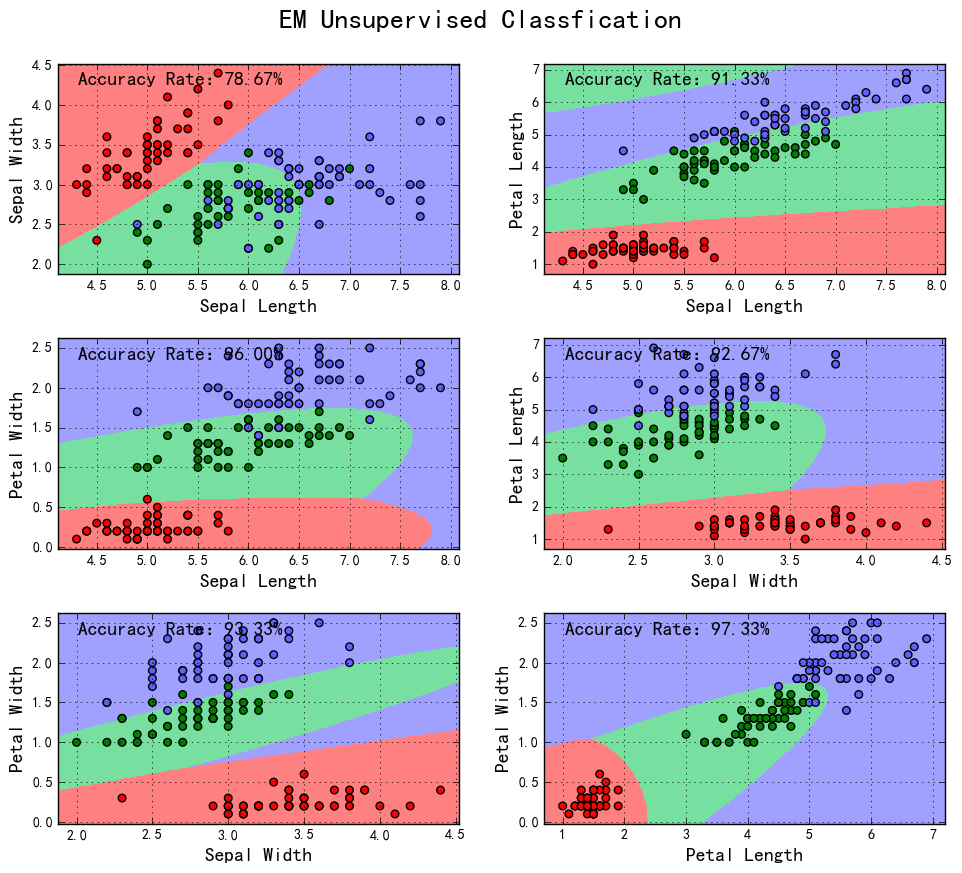

In [131]:
#  plot

plt.figure(figsize=(10, 9), facecolor='#FFFFFF')
for k,pair in enumerate(feature_pairs):
    x = x_prime[:, pair]
    m = np.array([np.mean(x[y == i], axis=0) for i in range(3)])  # actual x mean 
    print ('Actual Mean = \n', m) # 3 by 2 matrix 

    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
    gmm.fit(x)
    print ('Predicted Mean = \n', gmm.means_)
    print ('Predicted Covariance = \n', gmm.covariances_)
    y_hat = gmm.predict(x)
    order = pairwise_distances_argmin(m, gmm.means_, axis=1, metric='euclidean')
    print ('Order：\t', order) # compare the order or actual mean and predicted mean

    n_sample = y.size
    n_types = 3
    # re-order the predicted y so the order matches with actual means
    change = np.empty((n_types, n_sample), dtype=np.bool)
    for i in range(n_types):
        change[i] = y_hat == order[i]
    for i in range(n_types):
        y_hat[change[i]] = i
    acc = 'Accuracy Rate：%.2f%%' % (100*np.mean(y_hat == y))
    print (acc)
    # plot
    cm_light = mpl.colors.ListedColormap(['#FF8080', '#77E0A0', '#A0A0FF'])
    cm_dark = mpl.colors.ListedColormap(['r', 'g', '#6060FF'])
    x1_min, x1_max = x[:, 0].min(), x[:, 0].max()
    x2_min, x2_max = x[:, 1].min(), x[:, 1].max()
    x1_min, x1_max = expand(x1_min, x1_max)
    x2_min, x2_max = expand(x2_min, x2_max)
    x1, x2 = np.mgrid[x1_min:x1_max:500j, x2_min:x2_max:500j]
    grid_test = np.stack((x1.flat, x2.flat), axis=1)
    grid_hat = gmm.predict(grid_test)

    change = np.empty((n_types, grid_hat.size), dtype=np.bool)
    for i in range(n_types):
        change[i] = grid_hat == order[i]
    for i in range(n_types):
        grid_hat[change[i]] = i

    grid_hat = grid_hat.reshape(x1.shape)
    plt.subplot(3, 2, k+1)
    plt.pcolormesh(x1, x2, grid_hat, cmap=cm_light)
    plt.scatter(x[:, 0], x[:, 1], s=30, c=y, marker='o', cmap=cm_dark, edgecolors='k')
    # location to add text
    xx = 0.95 * x1_min + 0.05 * x1_max
    yy = 0.1 * x2_min + 0.9 * x2_max
    plt.text(xx, yy, acc, fontsize=14)
    plt.xlim((x1_min, x1_max))
    plt.ylim((x2_min, x2_max))
    plt.xlabel(iris_feature[pair[0]], fontsize=14)
    plt.ylabel(iris_feature[pair[1]], fontsize=14)
    plt.grid()
plt.tight_layout(2)
plt.suptitle('EM Unsupervised Classfication', fontsize=20)
plt.subplots_adjust(top=0.92)
plt.show()


### Dirichlet Process Gaussian Mixture Model

In [143]:
import numpy as np
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import scipy as sp
import matplotlib as mpl
import matplotlib.colors
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse


def expand(a, b, rate=0.05):
    d = (b - a) * rate
    return a-d, b+d


matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

In [144]:
# construct data 
np.random.seed(0)
cov1 = np.diag((1, 2))
N1 = 500
N2 = 300
N = N1 + N2
x1 = np.random.multivariate_normal(mean=(3, 2), cov=cov1, size=N1)
m = np.array(((1, 1), (1, 3)))
x1 = x1.dot(m)
x2 = np.random.multivariate_normal(mean=(-1, 10), cov=cov1, size=N2)
x = np.vstack((x1, x2))
y = np.array([0]*N1 + [1]*N2)
n_components = 3  # what if the n_components is NOT 2? 

In [145]:
# plot
colors = '#A0FFA0', '#2090E0', '#FF8080'
cm = mpl.colors.ListedColormap(colors)
x1_min, x1_max = x[:, 0].min(), x[:, 0].max()
x2_min, x2_max = x[:, 1].min(), x[:, 1].max()
x1_min, x1_max = expand(x1_min, x1_max)
x2_min, x2_max = expand(x2_min, x2_max)
x1, x2 = np.mgrid[x1_min:x1_max:500j, x2_min:x2_max:500j]
grid_test = np.stack((x1.flat, x2.flat), axis=1)

In [137]:
# help(BayesianGaussianMixture)

GMM Mean = 
 [[ -0.98543679  10.0756839 ]
 [  6.0239399   11.61448122]
 [  3.77430768   5.86579463]]
GMM Covariance = 
 [[[  0.89079177  -0.02572518]
  [ -0.02572518   1.95106592]]

 [[  1.6667472    3.58655076]
  [  3.58655076  10.40673433]]

 [[  1.5383593    3.21210121]
  [  3.21210121   9.04107582]]]
DPGMM Mean = 
 [[  4.8781165    8.69857677]
 [ -0.97330341  10.07291054]
 [  2.67198994   9.1912555 ]]
DPGMM Covariance = 
 [[[  2.88512063   6.60505025]
  [  6.60505025  17.9282858 ]]

 [[  0.96312229  -0.02851494]
  [ -0.02851494   1.98150421]]

 [[  5.1054577    1.12831439]
  [  1.12831439   6.18430272]]]


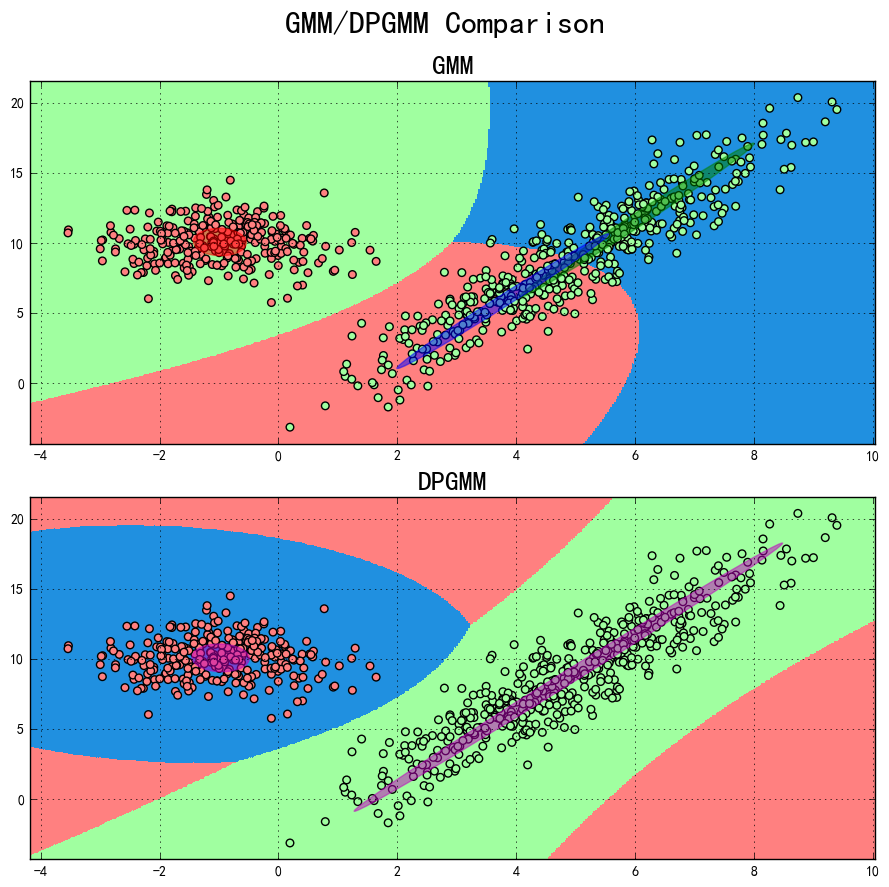

In [146]:
# plot
plt.figure(figsize=(9, 9), facecolor='w')
plt.suptitle('GMM/DPGMM Comparison', fontsize=23)

ax = plt.subplot(211)
gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
gmm.fit(x)
centers = gmm.means_
covs = gmm.covariances_
print ('GMM Mean = \n', centers)
print ('GMM Covariance = \n', covs)
y_hat = gmm.predict(x)

grid_hat = gmm.predict(grid_test)
grid_hat = grid_hat.reshape(x1.shape)
plt.pcolormesh(x1, x2, grid_hat, cmap=cm)
plt.scatter(x[:, 0], x[:, 1], s=30, c=y, cmap=cm, marker='o')

clrs = list('rgbmy')
for i, cc in enumerate(zip(centers, covs)):
    center, cov = cc
    value, vector = sp.linalg.eigh(cov)  # eigen value eigen vector
    width, height = value[0], value[1]
    v = vector[0] / sp.linalg.norm(vector[0])
    angle = 180* np.arctan(v[1] / v[0]) / np.pi
    e = Ellipse(xy=center, width=width, height=height,
                angle=angle, color=clrs[i], alpha=0.5, clip_box = ax.bbox)
    ax.add_artist(e)

ax1_min, ax1_max, ax2_min, ax2_max = plt.axis()
plt.xlim((x1_min, x1_max))
plt.ylim((x2_min, x2_max))
plt.title(u'GMM', fontsize=20)
plt.grid(True)

# DPGMM


dpgmm = BayesianGaussianMixture(n_components=n_components, covariance_type='full', max_iter=1000, n_init=5,
                                weight_concentration_prior_type='dirichlet_process', weight_concentration_prior=10)
dpgmm.fit(x)
centers = dpgmm.means_
covs = dpgmm.covariances_
print ('DPGMM Mean = \n', centers)
print ('DPGMM Covariance = \n', covs)
y_hat = dpgmm.predict(x)
# print (y_hat)

ax = plt.subplot(212)
grid_hat = dpgmm.predict(grid_test)
grid_hat = grid_hat.reshape(x1.shape)
plt.pcolormesh(x1, x2, grid_hat, cmap=cm)
plt.scatter(x[:, 0], x[:, 1], s=30, c=y, cmap=cm, marker='o')

for i, cc in enumerate(zip(centers, covs)):
    if i not in y_hat:
        continue
    center, cov = cc
    value, vector = sp.linalg.eigh(cov)
    width, height = value[0], value[1]
    v = vector[0] / sp.linalg.norm(vector[0])
    angle = 180* np.arctan(v[1] / v[0]) / np.pi
    e = Ellipse(xy=center, width=width, height=height,
                angle=angle, color='m', alpha=0.5, clip_box = ax.bbox)
    ax.add_artist(e)

plt.xlim((x1_min, x1_max))
plt.ylim((x2_min, x2_max))
plt.title('DPGMM', fontsize=20)
plt.grid(True)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


### GMM Likelihood Contours

In [147]:
import numpy as np
from sklearn.mixture import GaussianMixture
import scipy as sp
import matplotlib as mpl
import matplotlib.colors
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import warnings


def expand(a, b, rate=0.05):
    d = (b - a) * rate
    return a-d, b+d

In [149]:
warnings.filterwarnings(action='ignore', category=RuntimeWarning)
np.random.seed(0)
cov1 = np.diag((1, 2))
N1 = 500
N2 = 300
N = N1 + N2
x1 = np.random.multivariate_normal(mean=(3, 2), cov=cov1, size=N1)
m = np.array(((1, 1), (1, 3)))
x1 = x1.dot(m)
x2 = np.random.multivariate_normal(mean=(-1, 10), cov=cov1, size=N2)
x = np.vstack((x1, x2))
y = np.array([0]*N1 + [1]*N2)

gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
gmm.fit(x)
centers = gmm.means_
covs = gmm.covariances_
print ('GMM Mean = \n', centers)
print ('GMM Covariance = \n', covs)

GMM Mean = 
 [[ -0.9854541   10.07568927]
 [  4.88245286   8.69755   ]]
GMM Covariance = 
 [[[  0.89072605  -0.02570275]
  [ -0.02570275   1.95107155]]

 [[  2.86653758   6.62893122]
  [  6.62893122  17.97377445]]]


In [153]:
help(gmm.score_samples)

Help on method score_samples in module sklearn.mixture.base:

score_samples(X) method of sklearn.mixture.gaussian_mixture.GaussianMixture instance
    Compute the weighted log probabilities for each sample.
    
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        List of n_features-dimensional data points. Each row
        corresponds to a single data point.
    
    Returns
    -------
    log_prob : array, shape (n_samples,)
        Log probabilities of each data point in X.



score samples: 
 [-29.75101362 -29.9079518  -30.06590288 ...,  -8.08772322  -8.10398308
  -8.12125586]


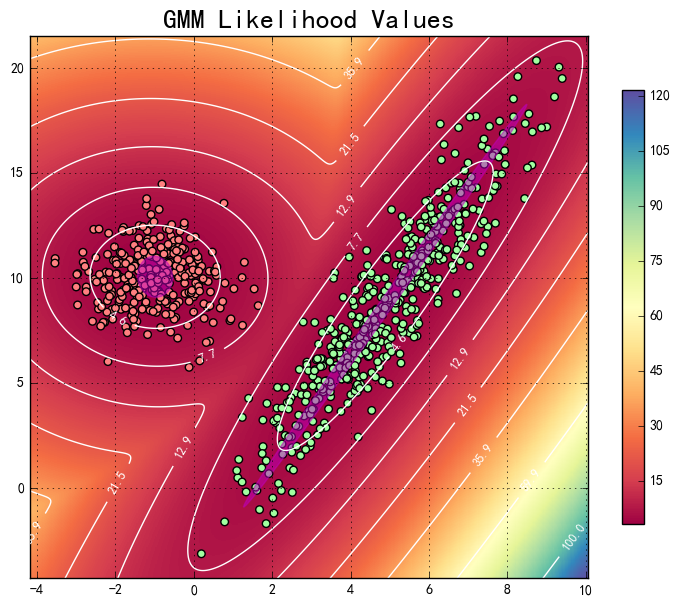

In [154]:
# prediction
y_hat = gmm.predict(x)

colors = '#A0FFA0', '#FF8080',
levels = 10
cm = mpl.colors.ListedColormap(colors)
x1_min, x1_max = x[:, 0].min(), x[:, 0].max()
x2_min, x2_max = x[:, 1].min(), x[:, 1].max()
x1_min, x1_max = expand(x1_min, x1_max)
x2_min, x2_max = expand(x2_min, x2_max)
x1, x2 = np.mgrid[x1_min:x1_max:500j, x2_min:x2_max:500j]
grid_test = np.stack((x1.flat, x2.flat), axis=1)
print ('score samples: \n',gmm.score_samples(grid_test)) # Compute the weighted log probabilities for each sample.
grid_hat = -gmm.score_samples(grid_test) # negative weighted log likelihood
grid_hat = grid_hat.reshape(x1.shape)
plt.figure(figsize=(9, 7), facecolor='w')
ax = plt.subplot(111)
cmesh = plt.pcolormesh(x1, x2, grid_hat, cmap=plt.cm.Spectral)
plt.colorbar(cmesh, shrink=0.8)
CS = plt.contour(x1, x2, grid_hat, levels=np.logspace(0, 2, num=levels, base=10), colors='w', linewidths=1)
plt.clabel(CS, fontsize=9, inline=1, fmt='%.1f')
plt.scatter(x[:, 0], x[:, 1], s=30, c=y, cmap=cm, marker='o')

for i, cc in enumerate(zip(centers, covs)):
    center, cov = cc
    value, vector = sp.linalg.eigh(cov)
    width, height = value[0], value[1]
    v = vector[0] / sp.linalg.norm(vector[0])
    angle = 180* np.arctan(v[1] / v[0]) / np.pi
    e = Ellipse(xy=center, width=width, height=height,
                angle=angle, color='m', alpha=0.5, clip_box = ax.bbox)
    ax.add_artist(e)

plt.xlim((x1_min, x1_max))
plt.ylim((x2_min, x2_max))
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False
plt.title(u'GMM Likelihood Values', fontsize=20)
plt.grid(True)
plt.show()
